In [2]:
from metasyn import MetaFrame
import time
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from tqdm import tqdm
import datetime as dt
from faker import Faker
from metasyn.distribution import UniformDistribution
#from datetime import date, time, datetime

In [2]:
def int_generator(size, n_col):
    for _ in range(n_col):
        yield pl.Series([np.random.randint(0, 1000, size=size) for i in range(n_col)])

In [3]:
def float_generator(size, n_col):
    return pl.DataFrame({"float" + str(i): np.random.rand(size) for i in range(n_col)})

In [4]:
def cat_generator(size, n_col):
    series_dict = {}
    for i in range(n_col):
        series_dict["cat" + str(i)] = pl.Series(np.random.choice(["category1", "othercat", "whatinthename"], size=size), dtype=pl.Categorical)
    return pl.DataFrame(series_dict)

In [5]:
def date_generator(size, n_col):
    return pl.DataFrame({"date"+str(i): [dt.date(1954, 1, x) for x in np.random.randint(1, 32, size=size)] for i in range(n_col)})

In [6]:
def time_generator(size, n_col):
    return pl.DataFrame({"time"+str(i): [dt.time(x, 12, 13) for x in np.random.randint(0, 24, size=size)] for i in range(n_col)})

In [7]:
def datetime_generator(size, n_col):
    return pl.DataFrame({"dt"+str(i): [dt.datetime(x, 10, 14) for x in np.random.randint(1956, 2021, size=size)] for i in range(n_col)})

In [8]:
def string_generator(size, n_col):
    fake = Faker()
    Faker.seed(12345)
    faker_types = ["address", "phone_number", "pricetag", "timezone", "mime_type", "unix_partition",
                   "ascii_email", "isbn10", "job", "ssn", "user_agent", "color", "license_plate",
                   "iban", "company", "time", "ipv4", "uri", "name"]
    series_dict = {}
    
    for i in range(n_col):
        cur_type = np.random.choice(faker_types)
        series_dict["str" + str(i)] = [getattr(fake, cur_type)() for _ in range(size)]
    return pl.DataFrame(series_dict)

In [9]:
def benchmark_once(distribution, df_generator, size, n_col=5):
    bench_times = []
    for series in df_generator:
        
        df = df_generator(size, n_col)
        start_time = time.time()
        MetaFrame.fit_dataframe(df)
        bench_times.append(time.time()-start_time)
    return np.mean(bench_times)

In [10]:
def fit(x, y):
    A = np.vstack([x, np.ones(len(x))]).T
    return np.linalg.lstsq(A, y, rcond=None)[0]

In [16]:
def benchmark(df_generator, plot=False, order=1):
    all_sizes = np.linspace(1, 100000//order, 20).astype(int)

    row_times = []
    for size in tqdm(all_sizes):
        row_times.append(benchmark_once(df_generator, size))
    a_row, b_row = fit(all_sizes, row_times)
    if plot:
        plt.plot(all_sizes, row_times)
        plt.plot(all_sizes, a_row*all_sizes+b_row)
        plt.show()

    sec_per_item = a_row/5
    all_n_col = 1+np.arange(10)
    col_times = []
    for n_col in tqdm(all_n_col):
        col_times.append(benchmark_once(df_generator, size=10000//order, n_col=n_col)-n_col*10000*sec_per_item//order)
    a_col, b_col = fit(all_n_col, col_times)

    if plot:
        plt.plot(all_n_col, col_times)
        plt.plot(all_n_col, a_col*all_n_col+b_col)
        plt.show()

    return b_col, a_col, sec_per_item

100%|███████████████████████████████████████████████████████████████| 20/20 [00:56<00:00,  2.81s/it]


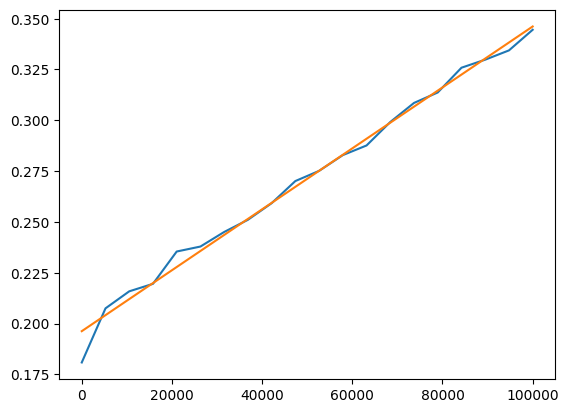

100%|███████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.40s/it]


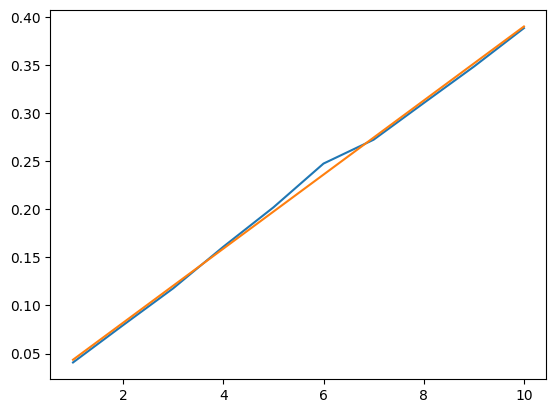

In [13]:
b_col_int, a_col_int, sec_per_item_int = benchmark(int_generator, plot=True, order=1)

In [15]:
b_col_float, a_col_float, sec_per_item_float = benchmark(float_generator, plot=True, order=1000)

 30%|███████████████████▏                                            | 6/20 [02:44<06:23, 27.37s/it]


KeyboardInterrupt: 

In [ ]:
b_col_cat, a_col_cat, sec_per_item_cat = benchmark(cat_generator, plot=True, order=10)

In [ ]:
b_col_date, a_col_date, sec_per_item_date = benchmark(date_generator, plot=True, order=1)

In [ ]:
b_col_time, a_col_time, sec_per_item_time = benchmark(time_generator, plot=True, order=10)

In [ ]:
b_col_dt, a_col_dt, sec_per_item_dt = benchmark(datetime_generator, plot=True, order=10)

100%|███████████████████████████████████████████████████████████████| 20/20 [21:37<00:00, 64.85s/it]


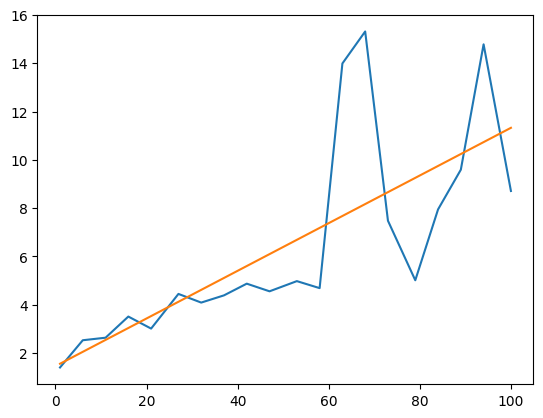

100%|███████████████████████████████████████████████████████████████| 10/10 [04:01<00:00, 24.12s/it]


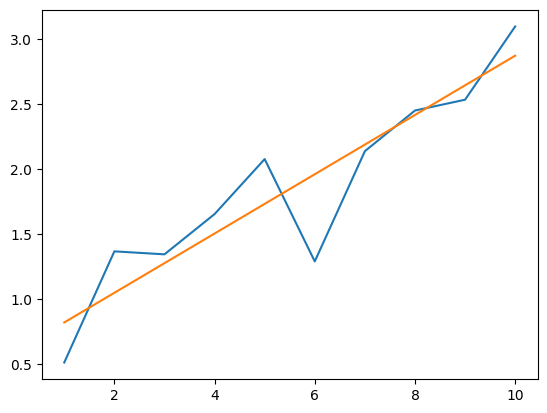

In [17]:
b_col_str, a_col_str, sec_per_item_str = benchmark(string_generator, plot=True, order=1000)